# Python scripting for network analysis — III
Lab session on March 5th

In [1]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Homework review

# Homework: ring & shortcuts network

We construct the following network:
1. ring of $N$ nodes with first and second neighbor connections
1. add $N/2$ shortcuts (additional edges) at random

Question: what is the average clustering coefficient of this network as $N \to \infty$?

1. Generate network
1. Measure quantity (average clustering)
1. Estimate for $N \to \infty$

# Generate network

1. Start with ring
1. Add shortcuts

In [2]:
import networkx
import matplotlib.pyplot as plt

def ring_network(N):
    g = networkx.Graph()
    for i in range(N):
        g.add_edge(i, (i+1)%N)
        g.add_edge(i, (i+2)%N)
    return g

In [3]:
import random
def add_shortcuts_first_try(graph):
    nodes = list(graph.nodes())
    for i in range(int(len(nodes)/2)):
        node_a = random.choice(nodes)
        node_b = random.choice(nodes)
        graph.add_edge(node_a, node_b)
    return graph

In [4]:
for i in range(10):
    g = add_shortcuts_first_try(ring_network(10))
    print(g.number_of_nodes(), g.number_of_edges())

10 24
10 22
10 21
10 23
10 22
10 23
10 24
10 22
10 24
10 21


In [5]:
import random
def add_shortcuts(graph):
    if graph.number_of_nodes() < 6:
        raise ValueError("network is too small!")
    nodes = list(graph.nodes())
    for i in range(int(len(nodes)/2)):
        node_a = random.choice(nodes)
        node_b = random.choice(nodes)
        while graph.has_edge(node_a, node_b) or node_a == node_b:
            node_a = random.choice(nodes)
            node_b = random.choice(nodes)   
        graph.add_edge(node_a, node_b)
    return graph

for i in range(10):
    g = add_shortcuts(ring_network(10))
    print(g.number_of_nodes(), g.number_of_edges())

10 25
10 25
10 25
10 25
10 25
10 25
10 25
10 25
10 25
10 25


# Estimating $N \to \infty$

In [6]:
networkx.average_clustering(add_shortcuts(ring_network(10)))

0.5809523809523809

In [7]:
networkx.average_clustering(add_shortcuts(ring_network(100)))

0.35037301587301584

In [8]:
networkx.average_clustering(add_shortcuts(ring_network(100000)))

0.34191382900428413

# Make convincing!

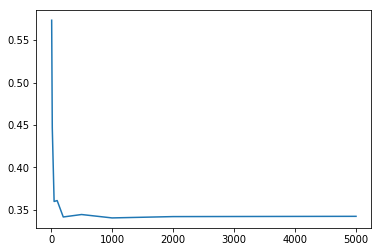

In [9]:
N_values = [10,20,50,100,200,500, 1000, 2000,5000]
values = [networkx.average_clustering(add_shortcuts(ring_network(N))) for N in N_values]
plt.plot(N_values, values)

In [10]:
values

[0.5733333333333335,
 0.446904761904762,
 0.3600000000000002,
 0.3610714285714285,
 0.3417619047619043,
 0.3446460317460319,
 0.34065000000000134,
 0.3421999999999986,
 0.34251857142856473]

# State the result!

* in this case, for example: "the average clustering as $N \to \infty$ is between 0.340 and 0.342"
* specifying interval allows showing the uncertainty of the estimate

# Does our result match the theoretical estimate?

* theoretical estimate was 0.3
* this is outside the range of our estimate ("between 0.340 and 0.342"), thus the two results don't match

# What causes the discrepancy?

* Is it the approximation done for the theoretical estimate? (that we ignore triangles created by the shortcut edges)

In [11]:
sum(networkx.triangles(ring_network(100)).values())/3.0

100.0

In [12]:
sum(networkx.triangles(add_shortcuts(ring_network(100))).values())/3.0

105.0

In [13]:
def additional_triangles2(N):
    return sum(networkx.triangles(add_shortcuts(ring_network(N))).values())/3.0 - sum(networkx.triangles(ring_network(N)).values())/3.0

In [14]:
additional_triangles2(100)

5.0

In [15]:
additional_triangles2(100000)

6.0

# What causes the discrepancy?
* We are calculating an average, which is doing something strange. A important lession about statistical quantities:

# Anscombe's quartet

* 11 (x,y) datapoints
* Mean & variance of x match exactly
* Mean & variance of y, correlation between x & y, fitted line (linear regression) match to at least 2 decimal places

<center><img src="Anscombe's_quartet.png" style="width:25%;"></center>

# Even better: Datasaurus
<center><img src="Datasaurus.gif" style="width:75%;"></center>
https://www.autodeskresearch.com/publications/samestats

# Let's look at what we are averaging!

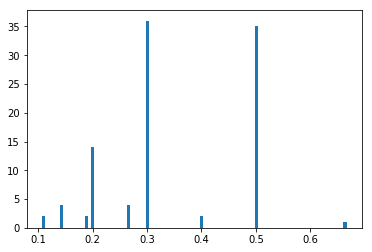

In [16]:
_ = plt.hist(list(networkx.clustering(add_shortcuts(ring_network(100))).values()), bins=100)

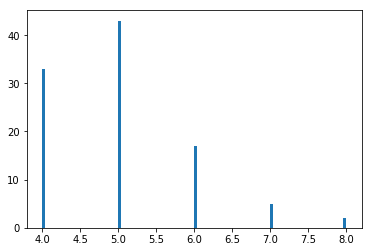

In [17]:
_ = plt.hist(list(dict(networkx.degree(add_shortcuts(ring_network(100)))).values()), bins=100)

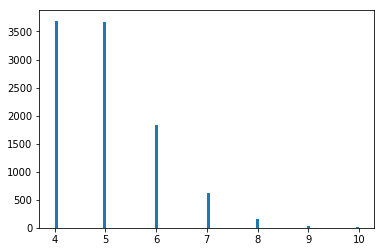

In [18]:
_ = plt.hist(list(dict(networkx.degree(add_shortcuts(ring_network(10000)))).values()), bins=100)

# Are we sure this explains the discrepancy?

* There is some difference between the two methods, but there might be others
* How can we check? → Homework assignment

# Calculating at a fixed $N$
* Given N, what is the average clustering coefficient of these networks?

One possible way to calculate: generate a single network, and use that:

In [19]:
networkx.average_clustering(add_shortcuts(ring_network(10000)))

0.3421695238095362

Obviously, we shouldn't use a single network for the estimate, but re-run it a few times:

In [20]:
networkx.average_clustering(add_shortcuts(ring_network(10000)))

0.3423485064935197

In [21]:
networkx.average_clustering(add_shortcuts(ring_network(10000)))

0.341968686868699

Even better, we can calculate an average of these:

In [22]:
values = [networkx.average_clustering(add_shortcuts(ring_network(10000))) for i in range(10)]

In [23]:
def avg(values):
    return sum(values) / len(values)

In [24]:
avg([networkx.average_clustering(add_shortcuts(ring_network(10000))) for i in range(10)])

0.34188237373738656

And re-run this average calculation, as well:

In [25]:
avg([networkx.average_clustering(add_shortcuts(ring_network(10000))) for i in range(10)])

0.34203490620491894

In [26]:
avg([networkx.average_clustering(add_shortcuts(ring_network(10000))) for i in range(10)])

0.3416269784104916

Of course, then we have the same problem as above -- do we average these averages? And then average those as well?

A better approach: show how our estimate changes as we use larger and larger number of networks -- this is essentially the same as we did for estimating for $N \to \infty$.

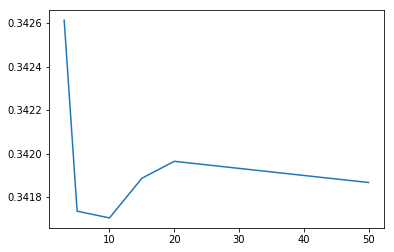

In [27]:
S_values = [3,5,10,15,20,50]
values = [avg([networkx.average_clustering(add_shortcuts(ring_network(10000))) for i in range(S)]) for S in S_values]
plt.plot(S_values, values)

Note that there is an even better way to do this: we don't need to generate a lot of new networks for every datapoint. Instead, we generate a single list of values, and then take successive averages of the first $n$ elements:

In [28]:
values = [networkx.average_clustering(add_shortcuts(ring_network(10000))) for i in range(100)]

In [29]:
averages = [avg(values[:S]) for S in range(3, len(values))]

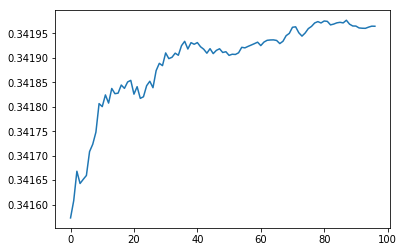

In [30]:
plt.plot(averages)

As before, we should specify our estimate, as an interval. In this case, that is: $0.34185$ to $0.34195$

# An important aspect about the sample sizes we might need:
* plotting the histogram of the values for different $N$ shows some interesting details:

In [31]:
values_100 = [networkx.average_clustering(add_shortcuts(ring_network(100))) for i in range(1000)]

In [32]:
values_50 = [networkx.average_clustering(add_shortcuts(ring_network(50))) for i in range(1000)]
values_25 = [networkx.average_clustering(add_shortcuts(ring_network(25))) for i in range(1000)]
values_10 = [networkx.average_clustering(add_shortcuts(ring_network(10))) for i in range(1000)]

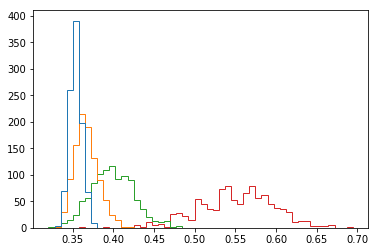

In [33]:
_ = plt.hist([values_100, values_50, values_25, values_10], bins=50, histtype='step')

For each $N$, the histogram shows a bell-shaped curve, which is wider for smaller $N$ and much narrower for larger $N$. The center of the peak moves to the left as $N$ increases.

Of these, the change in the width is a very general feature: most network quantites behave this way: using a larger network decreases the variance, which also lowers the required sample size (number of networks) needed for achieveing a given accuracy. The movement of the peak is specific to this problem, and this is the same as we have seen when plotting the convergence as a function of $N$ before.

# Some interesting features of the random module


We have used or mentioned:

In [7]:
import random
random.shuffle()
random.choice()

In [ ]:
But there is also:

In [8]:
random.seed()

# An example for using random.seed():

In [9]:
random.seed(42)
print(random.random())
print(random.random())
print(random.random())

0.6394267984578837
0.025010755222666936
0.27502931836911926


In [10]:
random.seed(42)
print(random.random())
print(random.random())
print(random.random())

0.6394267984578837
0.025010755222666936
0.27502931836911926


Which means that we can generate the same random numbers again -- does this make sense?

<center><img src="xkcd_random_number.png"></center>

### From https://xkcd.com/221/

## John von Neumann: "Anyone who attempts to generate random numbers by deterministic means is, of course, living in a state of sin."

# Having random.seed()
* is it a problem?
* what is it good for?

* PRNG: Pseudo Random Number Generator

* PRNG has internal state, updating that internal state every time it is used
* Starting point of internal state is set by seed()
* PRNG shouldn't be used for cryptography -- attacker might guess internal state, breaking the encryption
* Why can we use a PRNG for network analysis / simulation?

# What do we actually need?
* Want to calculate average over a set of objects
* Can't use all objects (like "networks of size N"), need to use a small sample to approximate
* As long as sample is unbiased, it is fine if it is deterministic

# Also: random.getstate(), random.setstate()

* Can't use random.seed() to get the current state of the PRNG -- need .getstate() for that
* Note that random.getstate() returns a much larger state than a hash of an object, which seed() uses to initialize if not a number is passed in
* seed() initializes in a small sub-space of the total possible states of the PRNG

In [12]:
random.getstate()

(3,
 (2468570525,
  44967195,
  2667364560,
  2449893699,
  1652692239,
  766678126,
  273175325,
  1513475390,
  2407048223,
  2326550691,
  3055735416,
  2487780036,
  476975371,
  81632736,
  1598452444,
  3338301038,
  3898475993,
  1749546629,
  4084786842,
  949316744,
  2086501466,
  4175211502,
  3792229788,
  1718685282,
  2499662139,
  4222931543,
  3063257123,
  910424605,
  1400804300,
  830603822,
  3216023045,
  2756927633,
  3684278863,
  3724968901,
  332416530,
  52016619,
  2751489098,
  1877715228,
  1932382287,
  3281876149,
  3597828351,
  330629843,
  142483984,
  1379430288,
  83784318,
  2266112133,
  1736800492,
  3746267091,
  2610492607,
  2079803227,
  3463890091,
  615297649,
  2445958069,
  138783768,
  741209753,
  3721915402,
  2027708325,
  4005341927,
  2093884772,
  119215273,
  551524651,
  3739622759,
  3782730527,
  404717681,
  321534867,
  1286801508,
  1706479953,
  2882329788,
  1029701930,
  2373551443,
  3296995744,
  468358352,
  746091816,
